In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import optim
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
from torchvision import utils
import torchvision


from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary
import numpy as np
import time
import copy
import random
from tqdm.auto import tqdm
import math

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

/home/eslab/anaconda3/envs/nyh38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda')

In [2]:
torch.cuda.device_count()

4

In [3]:
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(32),
])

train = torchvision.datasets.MNIST(root = "./", train = True, download = True, transform = transforms)
test = torchvision.datasets.MNIST(root = "./", train = False, download = True, transform = transforms)

In [4]:
train

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=32, interpolation=bilinear, max_size=None, antialias=None)
           )

In [5]:
test

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=32, interpolation=bilinear, max_size=None, antialias=None)
           )

In [6]:
f_cnt, n_cnt = 0, 0
train_four, train_nine = [], []
test_four, test_nine = [], []

def transform_degree_n6(img):
    return torchvision.transforms.functional.rotate(img = img, angle = -6)

def transform_degree_n3(img):
    return torchvision.transforms.functional.rotate(img = img, angle = -3)

def transform_degree_3(img):
    return torchvision.transforms.functional.rotate(img = img, angle = 3)

def transform_pixel(img):
    for i in range(6):
       coord = np.random.randint(0, img.shape[1], size = 2)
       img[0, coord[0], coord[1]] = 0
    
    return img

def aug_func(idx, img):
    if i == 0: img = transform_degree_n6(img)
    if i == 1: img = transform_degree_n3(img)
    if i == 2: img = transform_degree_3(img)
    if i == 3: img = transform_pixel(img)
    return img

for img, label in train:
    if label == 4:

        if f_cnt < 3000: 
            train_four.append(img)
            for i in range(0, 4): train_four.append(aug_func(i, img))
            f_cnt+=1

        elif f_cnt < 4000: test_four.append(img); f_cnt+=1
    
    elif label == 9: 
        if n_cnt < 3000: 
            train_nine.append(img)
            for i in range(0, 4): train_nine.append(aug_func(i, img))
            n_cnt+=1
        elif n_cnt < 4000: test_nine.append(img); n_cnt+=1

In [ ]:
test_four, test_nine = [], []
f_cnt, n_cnt = 0, 0

for img, label in test:
    if label == 4 and f_cnt < 900: # test nine has not enough images
        test_four.append(img)
        f_cnt += 1
    
    elif label == 9 and n_cnt < 900:
        test_nine.append(img)
        n_cnt += 1

In [ ]:
train_four.__len__(), train_nine.__len__(), test_four.__len__(), test_nine.__len__()

torch.Size([1, 32, 32])


(15000, 15000, 1000, 1000)

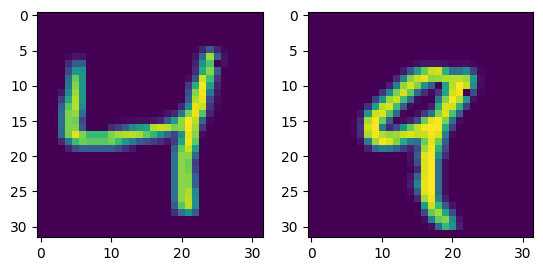

In [7]:
for f, n in zip(train_four, train_nine):
    plt.subplot(1, 2, 1); plt.imshow(f.permute(1,2,0))
    plt.subplot(1, 2, 2); plt.imshow(n.permute(1,2,0))    
    print(f.shape)
    break

In [8]:
train_f = [(img, 0) for img in train_four]
train_n = [(img, 1) for img in train_nine]

test_f = [(img, 0) for img in test_four]
test_n = [(img, 1) for img in test_nine]

train = train_f + train_n
test = test_f + test_n

random.shuffle(train)
random.shuffle(test)

traindata = [(img1[0], img2[0], 0) if img1[1] == img2[1] else (img1[0], img2[0], 1) for img1, img2 in zip(train[0::2], train[1::2])]

In [9]:
trainloader = DataLoader(traindata[3000:], batch_size=128, shuffle=True)
validloader = DataLoader(traindata[:3000], batch_size=128, shuffle=True)
trainloader.__len__(), validloader.__len__()

In [11]:
class DrLIM(nn.Module):

    def __init__(self):
        super().__init__()
        self.layer1 = nn.Conv2d(in_channels = 1, out_channels = 15, kernel_size = 6, padding = 0, stride = 1)
        self.relu = nn.ReLU()
        self.subsampling = nn.MaxPool2d(kernel_size = 3, stride = 3)
        self.layer2 = nn.Conv2d(in_channels = 15, out_channels = 30, kernel_size = 9, padding = 0, stride = 1)
        # self.relu = nn.ReLU(),
        self.fc = nn.Linear(15, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.subsampling(x)
        x = self.layer2(x)
        x = x.reshape(-1, 2, 15)
        x = self.relu(x)
        x = self.fc(x)
        return x
    

In [12]:
def CL_Loss(x1, x2, Y, m = 1):
    Euclidean_norm = torch.sqrt((x1 - x2)**2) # Euclidean Distance
    return torch.mean((1-Y).reshape(-1, 1, 1) * 1/2 * Euclidean_norm**2 + Y.reshape(-1, 1, 1) * 1/2 * torch.maximum(torch.Tensor([0]).to(device), m - Euclidean_norm)**2)

In [13]:
epochs = 200 # Iteration Number
cnt = 0      # early stopping count

model = DrLIM().to(device)
# criterion = CL_Loss()
optimizer = optim.SGD(model.parameters(), lr=0.001) # 기본적인 Adam 사용 후 lr 및 Optimizier 변경 예정

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model).to(device)

# save train and val Loss
train_loss = torch.zeros(epochs)
val_loss = torch.zeros(epochs)

# save train and val Acc
train_acc = torch.zeros(epochs)
val_acc = torch.zeros(epochs)

# initial loss value is inf.
valid_loss_min = np.Inf
valid_acc_max = 0

# train
for epoch in range(epochs):
    
    model.train() # train mode 
    
    for x1, x2, y in tqdm(trainloader):
        y = torch.tensor(y, dtype = torch.float64).to(device)
        x1, x2 = x1.to(device), x2.to(device)
        optimizer.zero_grad() # optimizer initialization
        
        Gw_x1 = model(x1) # model output of x1
        Gw_x2 = model(x2) # model output of x2
        
        # Calculate accuracy
        loss = CL_Loss(Gw_x1, Gw_x2, y) 
        loss.backward() # backward를 통해 역전파 실행 계산된 loss를 가지고 모델의 파라미터 개선
        optimizer.step() # optimizer.step()을 통해 개선된 파라미터 적용
        train_loss[epoch] += loss.item() # 에포크당 train_loss 누적

        ans = torch.tensor((Gw_x1[:, 0] < Gw_x1[:, 1]) != (Gw_x2[:, 0] < Gw_x2[:, 1]), dtype=torch.float64) # Similar to Contrastive Leaning Loss
        equals = ans == y.reshape(ans.shape)   # calculate acc
        train_acc[epoch] += torch.mean(equals.type(torch.FloatTensor)).item()  # 정확도 계산을 위해 float로 타입 변환 후 mean 계산.
    
    # AVG Loss
    train_loss[epoch] /= len(trainloader)
    train_acc[epoch] /= len(trainloader)

    
    # valid , 
    model.eval()  
    with torch.no_grad():  
        for x1, x2, y in tqdm(validloader):
            y = torch.tensor(y, dtype = torch.float64).to(device)
            x1, x2 = x1.to(device), x2.to(device)

            Gw_x1 = model(x1)
            Gw_x2 = model(x2)

            loss = CL_Loss(Gw_x1, Gw_x2, y) 
            val_loss[epoch] += loss.item() # Loss 값 누적

            
            ans = torch.tensor((Gw_x1[:, 0] < Gw_x1[:, 1]) != (Gw_x2[:, 0] < Gw_x2[:, 1]), dtype=torch.float64)
            equals = ans == y.reshape(ans.shape)   # 일치하는지 확인.
            val_acc[epoch] += torch.mean(equals.type(torch.FloatTensor)).item()  # 정확도 계산을 위해 float로 타입 변환 후 mean 계산.
            
    # validation Loss 및 accuracy 평균냄
    val_loss[epoch] /= len(validloader)
    val_acc[epoch] /= len(validloader)

    ##################### PRINT LOSS & ACC #####################
    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train loss: {train_loss[epoch]:.3f}.. "
          f"Train acc: {train_acc[epoch]:.3f}.. "
          f"val loss: {val_loss[epoch]:.3f}.. "
          f"val accuracy: {val_acc[epoch]:.3f}")

    ##################### 최적의 모델 저장 #####################
    if val_acc[epoch] >= valid_acc_max:
        print('Validation acc increased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_acc_max,
        val_acc[epoch]))
        torch.save(model.module.state_dict(), 'DrLIM.pt')
        valid_acc_max = val_acc[epoch]

        # 가장 낮은 Loss값을 가지게 된다면 Early Stopping count 초기화
        cnt = 0

    # 20번 이상 Loss 개선이 안된다면 종료
    ############# Early Stopping #############
    if cnt >= 10:
        print("Early Stopping")
        break
            
    cnt+=1 #Loss 개선 실패
########################################################

  0%|          | 0/94 [00:00<?, ?it/s]/tmp/ipykernel_17378/2079802684.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype = torch.float64).to(device)
/tmp/ipykernel_17378/2079802684.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ans = torch.tensor((Gw_x1[:, 0] < Gw_x1[:, 1]) != (Gw_x2[:, 0] < Gw_x2[:, 1]), dtype=torch.float64) # Similar to Contrastive Leaning Loss
  0%|          | 0/24 [00:00<?, ?it/s]/tmp/ipykernel_17378/2079802684.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, d

Epoch 1/200.. Train loss: 0.230.. Train acc: 0.514.. val loss: 0.228.. val accuracy: 0.514
Validation acc increased (0.000000 --> 0.513625).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 66.72it/s]


Epoch 2/200.. Train loss: 0.225.. Train acc: 0.534.. val loss: 0.222.. val accuracy: 0.532
Validation acc increased (0.513625 --> 0.532180).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 67.14it/s]


Epoch 3/200.. Train loss: 0.219.. Train acc: 0.540.. val loss: 0.216.. val accuracy: 0.555
Validation acc increased (0.532180 --> 0.555013).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 67.29it/s]


Epoch 4/200.. Train loss: 0.213.. Train acc: 0.539.. val loss: 0.208.. val accuracy: 0.555
Validation acc increased (0.555013 --> 0.555385).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 66.88it/s]


Epoch 5/200.. Train loss: 0.207.. Train acc: 0.541.. val loss: 0.202.. val accuracy: 0.555


100%|██████████| 24/24 [00:00<00:00, 68.46it/s]


Epoch 6/200.. Train loss: 0.201.. Train acc: 0.542.. val loss: 0.197.. val accuracy: 0.553


100%|██████████| 24/24 [00:00<00:00, 66.77it/s]


Epoch 7/200.. Train loss: 0.194.. Train acc: 0.542.. val loss: 0.190.. val accuracy: 0.554


100%|██████████| 24/24 [00:00<00:00, 67.36it/s]


Epoch 8/200.. Train loss: 0.188.. Train acc: 0.540.. val loss: 0.184.. val accuracy: 0.557
Validation acc increased (0.555385 --> 0.556873).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 67.12it/s]


Epoch 9/200.. Train loss: 0.182.. Train acc: 0.542.. val loss: 0.178.. val accuracy: 0.556


100%|██████████| 24/24 [00:00<00:00, 66.33it/s]


Epoch 10/200.. Train loss: 0.177.. Train acc: 0.545.. val loss: 0.172.. val accuracy: 0.557
Validation acc increased (0.556873 --> 0.557478).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 67.13it/s]


Epoch 11/200.. Train loss: 0.172.. Train acc: 0.548.. val loss: 0.168.. val accuracy: 0.557


100%|██████████| 24/24 [00:00<00:00, 66.89it/s]


Epoch 12/200.. Train loss: 0.167.. Train acc: 0.550.. val loss: 0.163.. val accuracy: 0.558
Validation acc increased (0.557478 --> 0.558361).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 66.91it/s]


Epoch 13/200.. Train loss: 0.163.. Train acc: 0.555.. val loss: 0.158.. val accuracy: 0.566
Validation acc increased (0.558361 --> 0.566313).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 66.84it/s]


Epoch 14/200.. Train loss: 0.159.. Train acc: 0.558.. val loss: 0.155.. val accuracy: 0.571
Validation acc increased (0.566313 --> 0.571196).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 67.03it/s]


Epoch 15/200.. Train loss: 0.156.. Train acc: 0.563.. val loss: 0.151.. val accuracy: 0.578
Validation acc increased (0.571196 --> 0.577567).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 67.06it/s]


Epoch 16/200.. Train loss: 0.153.. Train acc: 0.567.. val loss: 0.149.. val accuracy: 0.582
Validation acc increased (0.577567 --> 0.581845).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 66.76it/s]


Epoch 17/200.. Train loss: 0.150.. Train acc: 0.574.. val loss: 0.145.. val accuracy: 0.591
Validation acc increased (0.581845 --> 0.590541).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 67.73it/s]


Epoch 18/200.. Train loss: 0.148.. Train acc: 0.580.. val loss: 0.142.. val accuracy: 0.600
Validation acc increased (0.590541 --> 0.600167).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 66.44it/s]


Epoch 19/200.. Train loss: 0.145.. Train acc: 0.588.. val loss: 0.140.. val accuracy: 0.609
Validation acc increased (0.600167 --> 0.608584).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 66.85it/s]


Epoch 20/200.. Train loss: 0.142.. Train acc: 0.596.. val loss: 0.137.. val accuracy: 0.618
Validation acc increased (0.608584 --> 0.618350).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 67.23it/s]


Epoch 21/200.. Train loss: 0.140.. Train acc: 0.607.. val loss: 0.134.. val accuracy: 0.624
Validation acc increased (0.618350 --> 0.623512).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 67.53it/s]


Epoch 22/200.. Train loss: 0.136.. Train acc: 0.617.. val loss: 0.131.. val accuracy: 0.635
Validation acc increased (0.623512 --> 0.634905).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 66.08it/s]


Epoch 23/200.. Train loss: 0.133.. Train acc: 0.628.. val loss: 0.128.. val accuracy: 0.643
Validation acc increased (0.634905 --> 0.642950).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 66.91it/s]


Epoch 24/200.. Train loss: 0.130.. Train acc: 0.640.. val loss: 0.124.. val accuracy: 0.659
Validation acc increased (0.642950 --> 0.658994).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 66.33it/s]


Epoch 25/200.. Train loss: 0.126.. Train acc: 0.654.. val loss: 0.121.. val accuracy: 0.676
Validation acc increased (0.658994 --> 0.675502).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 66.50it/s]


Epoch 26/200.. Train loss: 0.123.. Train acc: 0.670.. val loss: 0.117.. val accuracy: 0.691
Validation acc increased (0.675502 --> 0.690802).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 66.32it/s]


Epoch 27/200.. Train loss: 0.119.. Train acc: 0.686.. val loss: 0.114.. val accuracy: 0.698
Validation acc increased (0.690802 --> 0.697684).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 68.35it/s]


Epoch 28/200.. Train loss: 0.115.. Train acc: 0.702.. val loss: 0.110.. val accuracy: 0.720
Validation acc increased (0.697684 --> 0.719587).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 66.86it/s]


Epoch 29/200.. Train loss: 0.111.. Train acc: 0.719.. val loss: 0.106.. val accuracy: 0.730
Validation acc increased (0.719587 --> 0.729539).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 66.82it/s]


Epoch 30/200.. Train loss: 0.107.. Train acc: 0.740.. val loss: 0.102.. val accuracy: 0.755
Validation acc increased (0.729539 --> 0.754511).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 66.46it/s]


Epoch 31/200.. Train loss: 0.103.. Train acc: 0.759.. val loss: 0.098.. val accuracy: 0.774
Validation acc increased (0.754511 --> 0.773717).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 66.89it/s]


Epoch 32/200.. Train loss: 0.099.. Train acc: 0.778.. val loss: 0.094.. val accuracy: 0.785
Validation acc increased (0.773717 --> 0.784924).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 67.03it/s]


Epoch 33/200.. Train loss: 0.094.. Train acc: 0.796.. val loss: 0.090.. val accuracy: 0.803
Validation acc increased (0.784924 --> 0.803246).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 67.47it/s]


Epoch 34/200.. Train loss: 0.090.. Train acc: 0.810.. val loss: 0.087.. val accuracy: 0.816
Validation acc increased (0.803246 --> 0.816174).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 66.84it/s]


Epoch 35/200.. Train loss: 0.086.. Train acc: 0.829.. val loss: 0.083.. val accuracy: 0.832
Validation acc increased (0.816174 --> 0.832403).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 67.28it/s]


Epoch 36/200.. Train loss: 0.083.. Train acc: 0.841.. val loss: 0.079.. val accuracy: 0.848
Validation acc increased (0.832403 --> 0.847935).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 67.32it/s]


Epoch 37/200.. Train loss: 0.079.. Train acc: 0.853.. val loss: 0.075.. val accuracy: 0.859
Validation acc increased (0.847935 --> 0.858770).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 67.05it/s]


Epoch 38/200.. Train loss: 0.075.. Train acc: 0.865.. val loss: 0.072.. val accuracy: 0.869
Validation acc increased (0.858770 --> 0.869327).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 67.12it/s]


Epoch 39/200.. Train loss: 0.071.. Train acc: 0.877.. val loss: 0.068.. val accuracy: 0.881
Validation acc increased (0.869327 --> 0.881278).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 67.53it/s]


Epoch 40/200.. Train loss: 0.068.. Train acc: 0.886.. val loss: 0.065.. val accuracy: 0.886
Validation acc increased (0.881278 --> 0.886161).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 66.18it/s]


Epoch 41/200.. Train loss: 0.065.. Train acc: 0.892.. val loss: 0.062.. val accuracy: 0.895
Validation acc increased (0.886161 --> 0.894903).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 66.39it/s]


Epoch 42/200.. Train loss: 0.062.. Train acc: 0.898.. val loss: 0.060.. val accuracy: 0.901
Validation acc increased (0.894903 --> 0.900995).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 67.58it/s]


Epoch 43/200.. Train loss: 0.059.. Train acc: 0.903.. val loss: 0.058.. val accuracy: 0.908
Validation acc increased (0.900995 --> 0.908064).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 66.00it/s]


Epoch 44/200.. Train loss: 0.057.. Train acc: 0.909.. val loss: 0.056.. val accuracy: 0.913
Validation acc increased (0.908064 --> 0.912946).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 66.90it/s]


Epoch 45/200.. Train loss: 0.055.. Train acc: 0.913.. val loss: 0.054.. val accuracy: 0.914
Validation acc increased (0.912946 --> 0.914249).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 67.01it/s]


Epoch 46/200.. Train loss: 0.053.. Train acc: 0.918.. val loss: 0.053.. val accuracy: 0.918
Validation acc increased (0.914249 --> 0.917829).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 66.76it/s]


Epoch 47/200.. Train loss: 0.052.. Train acc: 0.920.. val loss: 0.051.. val accuracy: 0.923
Validation acc increased (0.917829 --> 0.923224).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 68.41it/s]


Epoch 48/200.. Train loss: 0.050.. Train acc: 0.923.. val loss: 0.050.. val accuracy: 0.925
Validation acc increased (0.923224 --> 0.924991).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 66.45it/s]


Epoch 49/200.. Train loss: 0.049.. Train acc: 0.925.. val loss: 0.049.. val accuracy: 0.927
Validation acc increased (0.924991 --> 0.927269).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 66.57it/s]


Epoch 50/200.. Train loss: 0.048.. Train acc: 0.927.. val loss: 0.047.. val accuracy: 0.931
Validation acc increased (0.927269 --> 0.930897).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 66.39it/s]


Epoch 51/200.. Train loss: 0.047.. Train acc: 0.929.. val loss: 0.047.. val accuracy: 0.933
Validation acc increased (0.930897 --> 0.932803).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 66.74it/s]


Epoch 52/200.. Train loss: 0.046.. Train acc: 0.929.. val loss: 0.046.. val accuracy: 0.934
Validation acc increased (0.932803 --> 0.934477).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 67.00it/s]


Epoch 53/200.. Train loss: 0.045.. Train acc: 0.931.. val loss: 0.045.. val accuracy: 0.934


100%|██████████| 24/24 [00:00<00:00, 67.31it/s]


Epoch 54/200.. Train loss: 0.045.. Train acc: 0.931.. val loss: 0.045.. val accuracy: 0.935
Validation acc increased (0.934477 --> 0.935175).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 65.72it/s]


Epoch 55/200.. Train loss: 0.044.. Train acc: 0.932.. val loss: 0.044.. val accuracy: 0.936
Validation acc increased (0.935175 --> 0.936244).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 67.19it/s]


Epoch 56/200.. Train loss: 0.043.. Train acc: 0.933.. val loss: 0.043.. val accuracy: 0.935


100%|██████████| 24/24 [00:00<00:00, 66.99it/s]


Epoch 57/200.. Train loss: 0.043.. Train acc: 0.934.. val loss: 0.042.. val accuracy: 0.936


100%|██████████| 24/24 [00:00<00:00, 66.93it/s]


Epoch 58/200.. Train loss: 0.042.. Train acc: 0.934.. val loss: 0.042.. val accuracy: 0.938
Validation acc increased (0.936244 --> 0.938430).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 66.58it/s]


Epoch 59/200.. Train loss: 0.042.. Train acc: 0.935.. val loss: 0.041.. val accuracy: 0.940
Validation acc increased (0.938430 --> 0.940337).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 66.33it/s]


Epoch 60/200.. Train loss: 0.041.. Train acc: 0.936.. val loss: 0.041.. val accuracy: 0.939


100%|██████████| 24/24 [00:00<00:00, 67.93it/s]


Epoch 61/200.. Train loss: 0.041.. Train acc: 0.937.. val loss: 0.041.. val accuracy: 0.940


100%|██████████| 24/24 [00:00<00:00, 67.65it/s]


Epoch 62/200.. Train loss: 0.040.. Train acc: 0.938.. val loss: 0.040.. val accuracy: 0.940


100%|██████████| 24/24 [00:00<00:00, 67.59it/s]


Epoch 63/200.. Train loss: 0.040.. Train acc: 0.938.. val loss: 0.040.. val accuracy: 0.941
Validation acc increased (0.940337 --> 0.941220).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 66.70it/s]


Epoch 64/200.. Train loss: 0.040.. Train acc: 0.939.. val loss: 0.039.. val accuracy: 0.941
Validation acc increased (0.941220 --> 0.941453).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 67.08it/s]


Epoch 65/200.. Train loss: 0.039.. Train acc: 0.939.. val loss: 0.039.. val accuracy: 0.941


100%|██████████| 24/24 [00:00<00:00, 66.76it/s]


Epoch 66/200.. Train loss: 0.039.. Train acc: 0.940.. val loss: 0.039.. val accuracy: 0.942
Validation acc increased (0.941453 --> 0.941871).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 66.04it/s]


Epoch 67/200.. Train loss: 0.039.. Train acc: 0.940.. val loss: 0.038.. val accuracy: 0.943
Validation acc increased (0.941871 --> 0.942615).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 67.50it/s]


Epoch 68/200.. Train loss: 0.038.. Train acc: 0.940.. val loss: 0.038.. val accuracy: 0.944
Validation acc increased (0.942615 --> 0.944336).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 66.79it/s]


Epoch 69/200.. Train loss: 0.038.. Train acc: 0.941.. val loss: 0.038.. val accuracy: 0.942


100%|██████████| 24/24 [00:00<00:00, 66.49it/s]


Epoch 70/200.. Train loss: 0.038.. Train acc: 0.941.. val loss: 0.038.. val accuracy: 0.943


100%|██████████| 24/24 [00:00<00:00, 66.86it/s]


Epoch 71/200.. Train loss: 0.037.. Train acc: 0.942.. val loss: 0.037.. val accuracy: 0.943


100%|██████████| 24/24 [00:00<00:00, 66.75it/s]


Epoch 72/200.. Train loss: 0.037.. Train acc: 0.942.. val loss: 0.037.. val accuracy: 0.946
Validation acc increased (0.944336 --> 0.945871).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 67.35it/s]


Epoch 73/200.. Train loss: 0.037.. Train acc: 0.942.. val loss: 0.037.. val accuracy: 0.947
Validation acc increased (0.945871 --> 0.946522).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 68.06it/s]


Epoch 74/200.. Train loss: 0.037.. Train acc: 0.942.. val loss: 0.037.. val accuracy: 0.946


100%|██████████| 24/24 [00:00<00:00, 66.79it/s]


Epoch 75/200.. Train loss: 0.036.. Train acc: 0.943.. val loss: 0.036.. val accuracy: 0.947
Validation acc increased (0.946522 --> 0.946987).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 67.55it/s]


Epoch 76/200.. Train loss: 0.036.. Train acc: 0.943.. val loss: 0.036.. val accuracy: 0.948
Validation acc increased (0.946987 --> 0.947917).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 67.45it/s]


Epoch 77/200.. Train loss: 0.036.. Train acc: 0.943.. val loss: 0.036.. val accuracy: 0.947


100%|██████████| 24/24 [00:00<00:00, 66.92it/s]


Epoch 78/200.. Train loss: 0.036.. Train acc: 0.944.. val loss: 0.036.. val accuracy: 0.946


100%|██████████| 24/24 [00:00<00:00, 67.35it/s]


Epoch 79/200.. Train loss: 0.036.. Train acc: 0.945.. val loss: 0.035.. val accuracy: 0.948
Validation acc increased (0.947917 --> 0.948475).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 67.14it/s]


Epoch 80/200.. Train loss: 0.035.. Train acc: 0.944.. val loss: 0.035.. val accuracy: 0.949
Validation acc increased (0.948475 --> 0.948893).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 67.53it/s]


Epoch 81/200.. Train loss: 0.035.. Train acc: 0.945.. val loss: 0.035.. val accuracy: 0.947


100%|██████████| 24/24 [00:00<00:00, 67.32it/s]


Epoch 82/200.. Train loss: 0.035.. Train acc: 0.946.. val loss: 0.035.. val accuracy: 0.948


100%|██████████| 24/24 [00:00<00:00, 67.66it/s]


Epoch 83/200.. Train loss: 0.035.. Train acc: 0.946.. val loss: 0.035.. val accuracy: 0.947


100%|██████████| 24/24 [00:00<00:00, 66.29it/s]


Epoch 84/200.. Train loss: 0.034.. Train acc: 0.946.. val loss: 0.034.. val accuracy: 0.948


100%|██████████| 24/24 [00:00<00:00, 67.64it/s]


Epoch 85/200.. Train loss: 0.034.. Train acc: 0.946.. val loss: 0.034.. val accuracy: 0.948


100%|██████████| 24/24 [00:00<00:00, 68.68it/s]


Epoch 86/200.. Train loss: 0.034.. Train acc: 0.947.. val loss: 0.034.. val accuracy: 0.948


100%|██████████| 24/24 [00:00<00:00, 67.04it/s]


Epoch 87/200.. Train loss: 0.034.. Train acc: 0.947.. val loss: 0.034.. val accuracy: 0.947


100%|██████████| 24/24 [00:00<00:00, 66.97it/s]


Epoch 88/200.. Train loss: 0.034.. Train acc: 0.947.. val loss: 0.034.. val accuracy: 0.949


100%|██████████| 24/24 [00:00<00:00, 66.73it/s]


Epoch 89/200.. Train loss: 0.034.. Train acc: 0.947.. val loss: 0.034.. val accuracy: 0.949
Validation acc increased (0.948893 --> 0.949126).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 67.27it/s]


Epoch 90/200.. Train loss: 0.033.. Train acc: 0.947.. val loss: 0.033.. val accuracy: 0.949
Validation acc increased (0.949126 --> 0.949126).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 67.09it/s]


Epoch 91/200.. Train loss: 0.033.. Train acc: 0.948.. val loss: 0.033.. val accuracy: 0.948


100%|██████████| 24/24 [00:00<00:00, 67.05it/s]


Epoch 92/200.. Train loss: 0.033.. Train acc: 0.948.. val loss: 0.033.. val accuracy: 0.949


100%|██████████| 24/24 [00:00<00:00, 67.65it/s]


Epoch 93/200.. Train loss: 0.033.. Train acc: 0.948.. val loss: 0.033.. val accuracy: 0.950
Validation acc increased (0.949126 --> 0.949870).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 67.43it/s]


Epoch 94/200.. Train loss: 0.033.. Train acc: 0.948.. val loss: 0.033.. val accuracy: 0.948


100%|██████████| 24/24 [00:00<00:00, 66.22it/s]


Epoch 95/200.. Train loss: 0.033.. Train acc: 0.948.. val loss: 0.033.. val accuracy: 0.948


100%|██████████| 24/24 [00:00<00:00, 67.71it/s]


Epoch 96/200.. Train loss: 0.033.. Train acc: 0.948.. val loss: 0.032.. val accuracy: 0.948


100%|██████████| 24/24 [00:00<00:00, 66.77it/s]


Epoch 97/200.. Train loss: 0.032.. Train acc: 0.949.. val loss: 0.032.. val accuracy: 0.949


100%|██████████| 24/24 [00:00<00:00, 66.44it/s]


Epoch 98/200.. Train loss: 0.032.. Train acc: 0.948.. val loss: 0.033.. val accuracy: 0.947


100%|██████████| 24/24 [00:00<00:00, 66.84it/s]


Epoch 99/200.. Train loss: 0.032.. Train acc: 0.949.. val loss: 0.032.. val accuracy: 0.950
Validation acc increased (0.949870 --> 0.950102).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 66.67it/s]


Epoch 100/200.. Train loss: 0.032.. Train acc: 0.949.. val loss: 0.032.. val accuracy: 0.950


100%|██████████| 24/24 [00:00<00:00, 66.52it/s]


Epoch 101/200.. Train loss: 0.032.. Train acc: 0.949.. val loss: 0.032.. val accuracy: 0.951
Validation acc increased (0.950102 --> 0.950846).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 66.50it/s]


Epoch 102/200.. Train loss: 0.032.. Train acc: 0.950.. val loss: 0.032.. val accuracy: 0.951


100%|██████████| 24/24 [00:00<00:00, 66.73it/s]


Epoch 103/200.. Train loss: 0.032.. Train acc: 0.950.. val loss: 0.032.. val accuracy: 0.950


100%|██████████| 24/24 [00:00<00:00, 67.42it/s]


Epoch 104/200.. Train loss: 0.032.. Train acc: 0.950.. val loss: 0.032.. val accuracy: 0.951
Validation acc increased (0.950846 --> 0.951218).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 66.67it/s]


Epoch 105/200.. Train loss: 0.031.. Train acc: 0.951.. val loss: 0.032.. val accuracy: 0.951


100%|██████████| 24/24 [00:00<00:00, 66.70it/s]


Epoch 106/200.. Train loss: 0.031.. Train acc: 0.951.. val loss: 0.032.. val accuracy: 0.952
Validation acc increased (0.951218 --> 0.951869).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 66.20it/s]


Epoch 107/200.. Train loss: 0.031.. Train acc: 0.951.. val loss: 0.031.. val accuracy: 0.951


100%|██████████| 24/24 [00:00<00:00, 66.93it/s]


Epoch 108/200.. Train loss: 0.031.. Train acc: 0.951.. val loss: 0.031.. val accuracy: 0.953
Validation acc increased (0.951869 --> 0.953358).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 68.15it/s]


Epoch 109/200.. Train loss: 0.031.. Train acc: 0.951.. val loss: 0.032.. val accuracy: 0.953


100%|██████████| 24/24 [00:00<00:00, 66.49it/s]


Epoch 110/200.. Train loss: 0.031.. Train acc: 0.952.. val loss: 0.031.. val accuracy: 0.953


100%|██████████| 24/24 [00:00<00:00, 65.88it/s]


Epoch 111/200.. Train loss: 0.031.. Train acc: 0.952.. val loss: 0.031.. val accuracy: 0.954
Validation acc increased (0.953358 --> 0.953590).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 66.34it/s]


Epoch 112/200.. Train loss: 0.031.. Train acc: 0.952.. val loss: 0.031.. val accuracy: 0.955
Validation acc increased (0.953590 --> 0.955078).  Saving model ...


100%|██████████| 24/24 [00:00<00:00, 67.06it/s]


Epoch 113/200.. Train loss: 0.031.. Train acc: 0.952.. val loss: 0.031.. val accuracy: 0.954


100%|██████████| 24/24 [00:00<00:00, 67.11it/s]


Epoch 114/200.. Train loss: 0.030.. Train acc: 0.952.. val loss: 0.030.. val accuracy: 0.954


100%|██████████| 24/24 [00:00<00:00, 66.42it/s]


Epoch 115/200.. Train loss: 0.030.. Train acc: 0.953.. val loss: 0.031.. val accuracy: 0.954


100%|██████████| 24/24 [00:00<00:00, 66.14it/s]


Epoch 116/200.. Train loss: 0.030.. Train acc: 0.953.. val loss: 0.030.. val accuracy: 0.955


100%|██████████| 24/24 [00:00<00:00, 67.87it/s]


Epoch 117/200.. Train loss: 0.030.. Train acc: 0.953.. val loss: 0.031.. val accuracy: 0.954


100%|██████████| 24/24 [00:00<00:00, 66.25it/s]


Epoch 118/200.. Train loss: 0.030.. Train acc: 0.953.. val loss: 0.030.. val accuracy: 0.954


100%|██████████| 24/24 [00:00<00:00, 68.60it/s]


Epoch 119/200.. Train loss: 0.030.. Train acc: 0.953.. val loss: 0.030.. val accuracy: 0.955


100%|██████████| 24/24 [00:00<00:00, 66.19it/s]


Epoch 120/200.. Train loss: 0.030.. Train acc: 0.954.. val loss: 0.030.. val accuracy: 0.954


100%|██████████| 24/24 [00:00<00:00, 66.28it/s]


Epoch 121/200.. Train loss: 0.030.. Train acc: 0.954.. val loss: 0.030.. val accuracy: 0.954


100%|██████████| 24/24 [00:00<00:00, 66.44it/s]

Epoch 122/200.. Train loss: 0.030.. Train acc: 0.954.. val loss: 0.030.. val accuracy: 0.954
Early Stopping
